In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [11]:
# read the illinois state shp data
illinois_shp = gpd.read_file('raw_il_census_tracts_shapefile/tl_2019_17_tract.shp')
illinois_shp = illinois_shp.loc[:,('GEOID','geometry')]
illinois_shp['centroid'] = illinois_shp.centroid.to_crs(epsg = 4326)
illinois_shp.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,GEOID,geometry,centroid
0,17091011700,"POLYGON ((-87.88768 41.13594, -87.88764 41.136...",POINT (-87.87355 41.12949)
1,17091011800,"POLYGON ((-87.89410 41.14388, -87.89400 41.143...",POINT (-87.87646 41.13978)
2,17119400951,"POLYGON ((-90.11192 38.70281, -90.11128 38.703...",POINT (-90.09829 38.72763)
3,17119400952,"POLYGON ((-90.09442 38.72031, -90.09360 38.720...",POINT (-90.08180 38.72984)
4,17135957500,"POLYGON ((-89.70369 39.34803, -89.69928 39.348...",POINT (-89.60391 39.38915)


In [12]:
def tripsDF_tripslineGDF(streetlight_OD_df_path):
    streetlight_OD_df = pd.read_csv(streetlight_OD_df_path)[['RESIDENCE','WORKPLACE','JOBS']]
    streetlight_OD_df.columns = ['START', 'END', 'RISK_FLOW'] 
    streetlight_OD_df['START'] = streetlight_OD_df['START'].astype(str)
    streetlight_OD_df['END'] = streetlight_OD_df['END'].astype(str)

    start_geo_df = pd.merge(streetlight_OD_df, illinois_shp, how='left', left_on='START', right_on='GEOID')
    start_geo_df = start_geo_df[['START', 'END', 'RISK_FLOW', 'centroid']]
    start_geo_df = start_geo_df.rename(columns = {'centroid' : 'START_centroid'})

    end_geo_df = pd.merge(start_geo_df, illinois_shp, how='left', left_on='END', right_on='GEOID')
    end_geo_df = end_geo_df[['START', 'END', 'RISK_FLOW', 'START_centroid', 'centroid']]
    end_geo_df = end_geo_df.rename(columns = {'centroid' : 'END_centroid'})

    geo_line_df = end_geo_df
    geo_line_df['FLOWLINES'] = pd.DataFrame([LineString([end_geo_df.loc[i, 'START_centroid'],
                                                     end_geo_df.loc[i, 'END_centroid']]) 
                                         for i in range(len(end_geo_df))])

    geo_trips_line_df = geo_line_df[['RISK_FLOW', 'FLOWLINES']]
    geo_trips_line_df.columns = ['RISK_FLOW','geometry']
    geo_trips_line_df['RISK_FLOW'] = geo_trips_line_df['RISK_FLOW']*10000
    mean_trips = np.mean(geo_trips_line_df['RISK_FLOW'])
    geo_trips_line_df = geo_trips_line_df[geo_trips_line_df['RISK_FLOW']> mean_trips]

    geo_trips_line_gdf = gpd.GeoDataFrame(geo_trips_line_df)
    return geo_trips_line_gdf

In [15]:
def drawTripsflows(geo_trips_line_gdf, png_path):
    base_map = illinois_shp.plot(color='white', 
                       edgecolor='black', 
                       alpha = 0.1, 
                       figsize = (9,12))

    trips_flow_map = geo_trips_line_gdf.plot(ax = base_map, 
                    column = 'RISK_FLOW', 
                    cmap='Oranges', 
                    scheme = 'percentiles',
                    legend=True,
                    markersize = 'RISK_FLOW', 
                    figsize = (5,4))

    # Adjust legend location
    leg = trips_flow_map.get_legend()
    leg.set_bbox_to_anchor((0.25,0.25))

    trips_flow_map.axis('off')
    plt.savefig(png_path, dpi = 200)

In [5]:
geo_trips_line1_gdf = tripsDF_tripslineGDF('Streetlight_Data/clean_data/streetlight_OD_p1.csv')
geo_trips_line2_gdf = tripsDF_tripslineGDF('Streetlight_Data/clean_data/streetlight_OD_p2.csv')
geo_trips_line3_gdf = tripsDF_tripslineGDF('Streetlight_Data/clean_data/streetlight_OD_p3.csv')
geo_trips_line4_gdf = tripsDF_tripslineGDF('Streetlight_Data/clean_data/streetlight_OD_p4.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


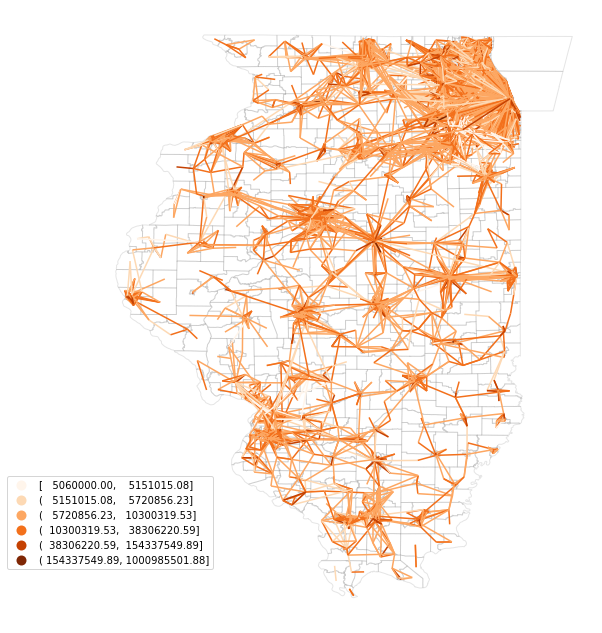

In [16]:
drawTripsflows(geo_trips_line_gdf = geo_trips_line1_gdf,
              png_path = 'Plots/trips_flows_map1.png')

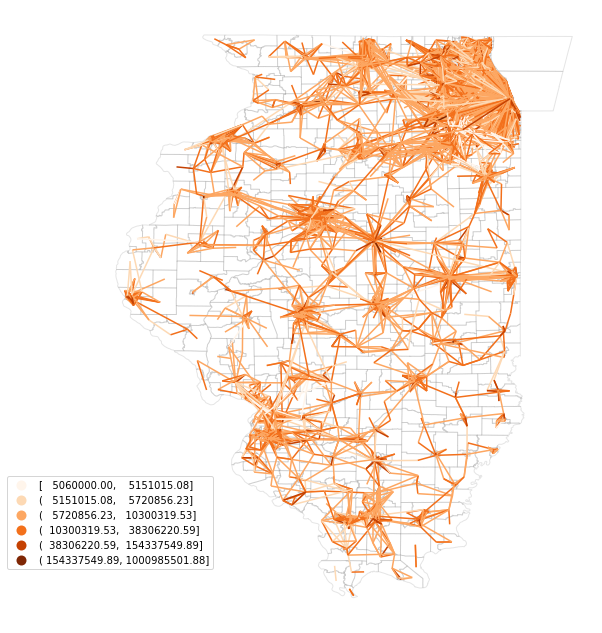

In [17]:
drawTripsflows(geo_trips_line_gdf = geo_trips_line2_gdf,
              png_path = 'Plots/trips_flows_map2.png')

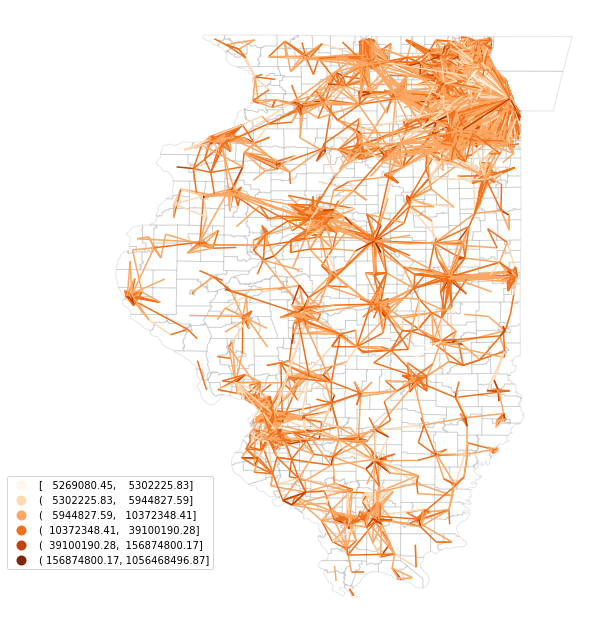

In [18]:
drawTripsflows(geo_trips_line_gdf = geo_trips_line3_gdf,
              png_path = 'Plots/trips_flows_map3.png')

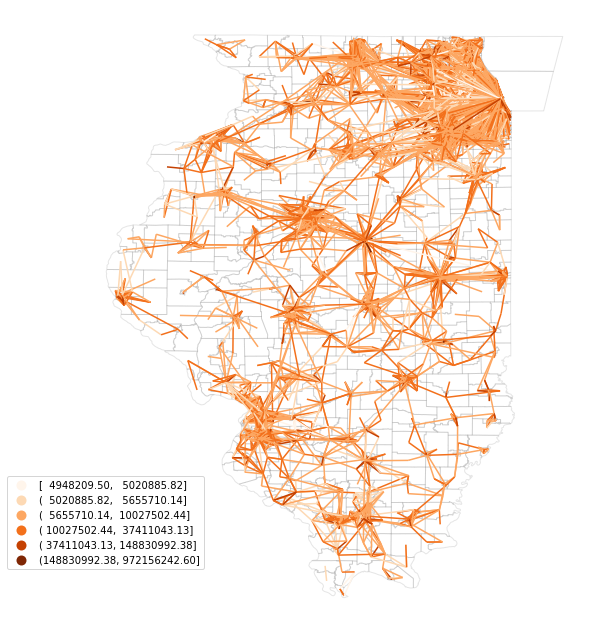

In [19]:
drawTripsflows(geo_trips_line_gdf = geo_trips_line4_gdf,
              png_path = 'Plots/trips_flows_map4.png')